## Self-Driving Car Engineer Nanodegree

** Vehicle Detection Project **


The goals / steps of this project are the following:

1. Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
2. Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
3. Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
4. Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
5. Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
6. Estimate a bounding box for vehicles detected.

### Set dependency

In [74]:
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os, sys 
sys.path.append('lib/')
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from scipy.ndimage.measurements import label
from vtcv.dataset import visualize_dataset as vd
from functools import partial
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import imageio
import time
imageio.plugins.ffmpeg.download()

### Initial Data Exploration

# sample : 43  sampling_rate : 0.005  # of data : 8793
size =  (768, 512, 3)


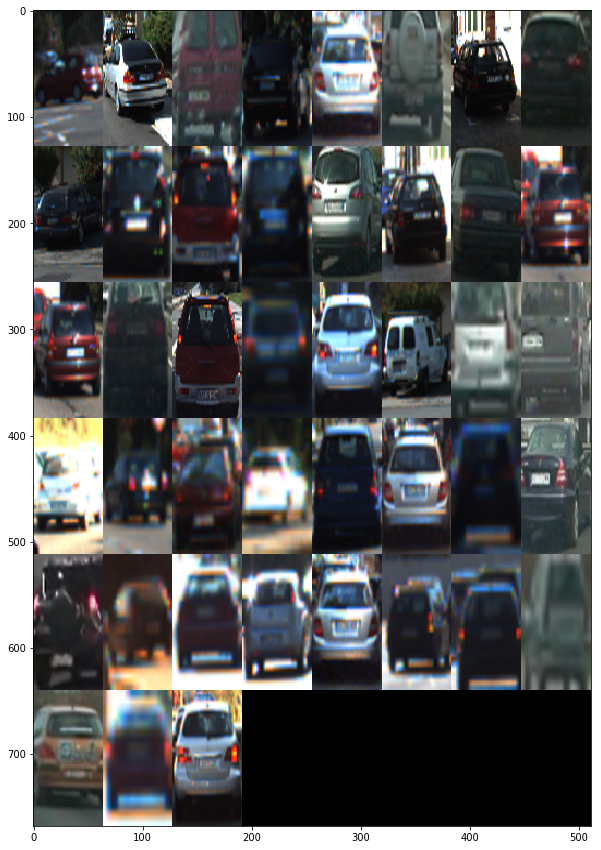

In [2]:
# Test images
test_imgs = vd.show_sampled_dataset_from_dir('dataset/prj_ds/vehicles',filepat='*.png',sampling_rate=0.005)

# sample : 448  sampling_rate : 0.05  # of data : 8969
size =  (2560, 1472, 3)


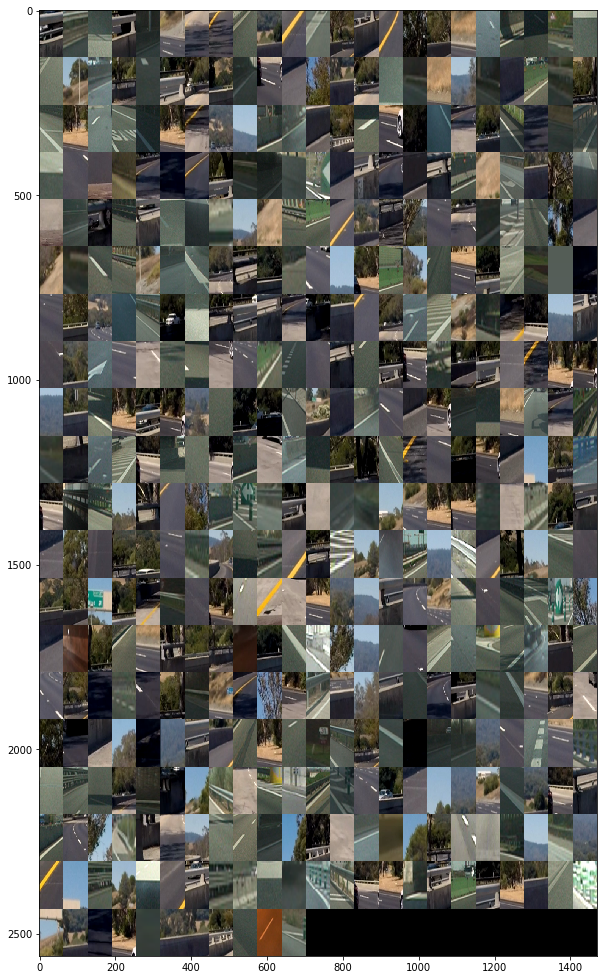

In [3]:
# Test images
test_imgs = vd.show_sampled_dataset_from_dir('dataset/prj_ds/non-vehicles',filepat='*.png',sampling_rate=0.05)

### Prepare Dataset

In [4]:
cars = glob.glob('dataset/prj_ds/vehicles/*/*.png')
notcars = glob.glob('dataset/prj_ds/non-vehicles/*/*.png')

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

In [5]:
data_info

{'n_cars': 8792,
 'n_notcars': 8968,
 'image_shape': (64, 64, 3),
 'data_type': dtype('float32')}

### Histogram of Oriented Gradients (HOG)

In [6]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True,
                     feature_vec=True):
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    
    # name returns explicitly
    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return return_list

### Sample HoG feature images

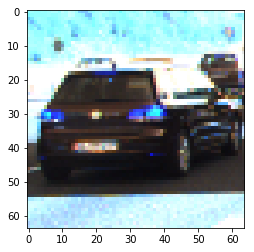

In [7]:
img = cv2.imread(cars[0])
plt.imshow(img)

In [8]:
cars[10]

'dataset/prj_ds/vehicles/KITTI_extracted/3210.png'

In [9]:
notcars[10]

'dataset/prj_ds/non-vehicles/GTI/image2194.png'

Text(0.5,1,'NonCar HOG Visualization')

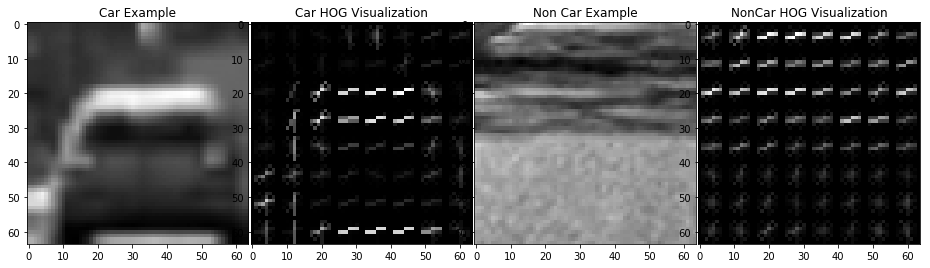

In [10]:
# Read in the image
car_ex = cv2.imread(cars[1])
car_ex_gray = cv2.cvtColor(car_ex, cv2.COLOR_BGR2GRAY)

noncar_ex = cv2.imread(notcars[1])
noncar_ex_gray = cv2.cvtColor(noncar_ex, cv2.COLOR_BGR2GRAY)

# Call our function with vis=True to see an image output
features, car_hog_image = get_hog_features(car_ex_gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True)

features, noncar_hog_image = get_hog_features(noncar_ex_gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=True)

# Plot the examples
fig, axs = plt.subplots(1,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .1, wspace=.01)
axs = axs.ravel()
#axs_set = [a.axis('off') for a in axs]
axs[0].imshow(car_ex_gray,cmap='gray')
axs[0].set_title('Car Example')
axs[1].imshow(car_hog_image,cmap='gray')
axs[1].set_title('Car HOG Visualization')
axs[2].imshow(noncar_ex_gray,cmap='gray')
axs[2].set_title('Non Car Example')
axs[3].imshow(noncar_hog_image,cmap='gray')
axs[3].set_title('NonCar HOG Visualization')


### Hog Feature configuration

In [11]:
feature_config = [
    {'clbl':0, 'cspc':'RGB', 'ori':9, 'ppc':8, 'cblk':2, 'ch':'ALL', 'etime':0 },
    {'clbl':1, 'cspc':'GRAY','ori':9, 'ppc':8, 'cblk':2, 'ch':0 ,    'etime':0 }, 
    
    {'clbl':2, 'cspc':'HLS', 'ori':9, 'ppc':8, 'cblk':2, 'ch':1 ,    'etime':0 },
    {'clbl':3, 'cspc':'HLS', 'ori':9, 'ppc':8, 'cblk':2, 'ch':2 ,    'etime':0 },
    {'clbl':4, 'cspc':'HLS', 'ori':9, 'ppc':8, 'cblk':2, 'ch':'ALL', 'etime':0 },

    {'clbl':5, 'cspc':'HSV', 'ori':9, 'ppc':8, 'cblk':2, 'ch':1    , 'etime':0 },
    {'clbl':6, 'cspc':'HSV', 'ori':9, 'ppc':8, 'cblk':2, 'ch':2    , 'etime':0 },
    {'clbl':7, 'cspc':'HSV', 'ori':9, 'ppc':8, 'cblk':2, 'ch':'ALL', 'etime':0 },
    
    {'clbl':8, 'cspc':'YUV', 'ori':9, 'ppc':8, 'cblk':2, 'ch':0    , 'etime':0 },
    {'clbl':9, 'cspc':'YUV', 'ori':9, 'ppc':8, 'cblk':2, 'ch':1    , 'etime':0 },
    {'clbl':10,'cspc':'YUV', 'ori':9, 'ppc':8, 'cblk':2, 'ch':2    , 'etime':0 },
    {'clbl':11,'cspc':'YUV', 'ori':9, 'ppc':8, 'cblk':2, 'ch':'ALL', 'etime':0 } 
]

### Prepare train / test set given configuration

In [12]:
def extract_features(imgs, fcfg) :
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        #image = mpimg.imread(file)
        image = cv2.imread(file)
        # apply color conversion if other than 'RGB'
        if fcfg['cspc'] != 'RGB':
            if fcfg['cspc'] == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif fcfg['cspc'] == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif fcfg['cspc'] == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif fcfg['cspc'] == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif fcfg['cspc'] == 'GRAY' :
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else: 
            feature_image = np.copy(image)

        if fcfg['ch'] == 'ALL' and len(feature_image.shape) == 3 :
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    fcfg['ori'], fcfg['ppc'], fcfg['cblk'], 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            if fcfg['cspc'] != 'GRAY' :
                hog_features = get_hog_features(feature_image[:,:,fcfg['ch']], 
                                    fcfg['ori'], fcfg['ppc'], fcfg['cblk'],
                                    vis=False, feature_vec=True)
            else :
                hog_features = get_hog_features(feature_image, 
                                    fcfg['ori'], fcfg['ppc'], fcfg['cblk'],
                                    vis=False, feature_vec=True)

        features.append(hog_features)
        
    return features

In [13]:
dataset = []

for fcfg in feature_config :
    ds = {} 
    t1 = time.time()
    car_features    = extract_features(cars, fcfg)
    notcar_features = extract_features(notcars, fcfg)
    fcfg['etime'] = round(time.time() - t1, 2)
    
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64) 
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    ds['clbl'] = fcfg['clbl']
    ds['X_train'] = X_train
    ds['y_train'] = y_train
    ds['X_test'] = X_test
    ds['y_test'] = y_test
    ds['X_scaler']= X_scaler
    
    dataset.append(ds)
    
df = pd.DataFrame(feature_config)
df.set_index('clbl')
df

,cblk,ch,clbl,cspc,etime,ori,ppc
0,2,ALL,0,RGB,183.61,9,8
1,2,0,1,GRAY,63.84,9,8
2,2,1,2,HLS,65.89,9,8
3,2,2,3,HLS,66.61,9,8
4,2,ALL,4,HLS,185.80,9,8
5,2,1,5,HSV,65.89,9,8
6,2,2,6,HSV,66.87,9,8
7,2,ALL,7,HSV,185.98,9,8
8,2,0,8,YUV,65.45,9,8
9,2,1,9,YUV,63.70,9,8


### Train a Classifier

In [77]:
def train_classifier(fcfg) :
    # Use a linear SVC 
    svc = LinearSVC() #SVC(kernel='rbf')
    
    ds = dataset[fcfg['clbl']]
    # Check the training time for the SVC
    t = time.time()
    svc.fit(ds['X_train'], ds['y_train'])
    t2 = time.time()
    fcfg['train_t']=round(t2-t, 2)
    fcfg['acc']=round(svc.score(ds['X_test'], ds['y_test']), 4)
    
    t = time.time()
    n_predict = 10
    
    # Check the prediction time for 10 samples
    t=time.time()
    n_predict = 10
    svc.predict(ds['X_test'][0:10])
    t2 = time.time()
    
    fcfg['10_pred_t'] = round(t2-t, 5)
    ds['model'] = svc

In [78]:
for fcfg in feature_config :
    train_classifier(fcfg)
    
df = pd.DataFrame(feature_config)
df.set_index('clbl')

,10_pred_t,acc,cblk,ch,cspc,etime,ori,ppc,train_t
clbl,,,,,,,,,
0,0.00020,0.9319,2,ALL,RGB,183.61,9,8,50.11
1,0.00015,0.9147,2,0,GRAY,63.84,9,8,23.94
2,0.00015,0.9240,2,1,HLS,65.89,9,8,27.30
3,0.00015,0.9037,2,2,HLS,66.61,9,8,34.77
4,0.00020,0.9499,2,ALL,HLS,185.80,9,8,34.16
5,0.00015,0.9088,2,1,HSV,65.89,9,8,31.03
6,0.00015,0.9206,2,2,HSV,66.87,9,8,25.86
7,0.00020,0.9538,2,ALL,HSV,185.98,9,8,33.14
8,0.00014,0.9150,2,0,YUV,65.45,9,8,23.16


In [17]:
## SVM with rbf kernel result

,10_pred_t,acc,cblk,ch,cspc,etime,ori,ppc,train_t
clbl,,,,,,,,,
0,0.27978,0.9490,2,ALL,RGB,183.61,9,8,415.89
1,0.09837,0.9378,2,0,GRAY,63.84,9,8,153.23
2,0.09675,0.9378,2,1,HLS,65.89,9,8,146.60
3,0.09807,0.9065,2,2,HLS,66.61,9,8,155.31
4,0.14901,0.9716,2,ALL,HLS,185.80,9,8,222.53
5,0.08682,0.9375,2,1,HSV,65.89,9,8,136.32
6,0.09635,0.9426,2,2,HSV,66.87,9,8,146.20
7,0.14311,0.9735,2,ALL,HSV,185.98,9,8,215.15
8,0.10005,0.9412,2,0,YUV,65.45,9,8,152.46


### Save trained model

In [79]:
def save_model(feature_config,datset,path) :
    with open('{}/feature_cfgs.pkl'.format(path), 'wb') as pkl_file :
        pickle.dump(feature_config, pkl_file) 
        
    for i in range(0, len(feature_config)) :
        joblib.dump(dataset[i]['model'],'{}/{}_model.clf'.format(path,i))
        scaler = dataset[i]['X_scaler']
        with open('{}/{}_X_scaler.pkl'.format(path,i), 'wb') as pkl_file :
            pickle.dump(scaler, pkl_file)

In [80]:
save_model(feature_config,dataset,'models/svm_linear')

In [81]:
with open('models/features/dataset_svm_linear.pkl', 'wb') as pkl_file :
    pickle.dump(dataset, pkl_file)

### Test Classifier

In [87]:
def load_model(path,mid) :
    with open('{}/feature_cfgs.pkl'.format(path), 'rb') as pkl_file :
        feature_config = pickle.load(pkl_file)
    fcfg = feature_config[mid]
    clf = joblib.load('{}/{}_model.clf'.format(path,mid))
    with open('{}/{}_X_scaler.pkl'.format(path,mid), 'rb') as pkl_file:
        X_scaler = pickle.load(pkl_file)
    
    return fcfg,clf,X_scalerdef load_model(path,mid) :
    with open('{}/feature_cfgs.pkl'.format(path), 'rb') as pkl_file :
        feature_config = pickle.load(pkl_file)
    fcfg = feature_config[mid]
    clf = joblib.load('{}/{}_model.clf'.format(path,mid))
    with open('{}/{}_X_scaler.pkl'.format(path,mid), 'rb') as pkl_file:
        X_scaler = pickle.load(pkl_file)
    
    return fcfg,clf,X_scaler

### Load model

In [109]:
def extract_feature(img, fcfg) :
    features = []
    
    image = img # img.astype(np.float32)/255
    
    # apply color conversion if other than 'RGB'
    if fcfg['cspc'] != 'RGB':
        if fcfg['cspc'] == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif fcfg['cspc'] == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
        elif fcfg['cspc'] == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        elif fcfg['cspc'] == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        elif fcfg['cspc'] == 'GRAY' :
            feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else: 
        feature_image = np.copy(image)

    if fcfg['ch'] == 'ALL' and len(feature_image.shape) == 3 :
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                fcfg['ori'], fcfg['ppc'], fcfg['cblk'], 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)
    else:
        if fcfg['cspc'] != 'GRAY' :
            hog_features = get_hog_features(feature_image[:,:,fcfg['ch']], 
                                fcfg['ori'], fcfg['ppc'], fcfg['cblk'],
                                vis=False, feature_vec=True)
        else :
            hog_features = get_hog_features(feature_image, 
                                fcfg['ori'], fcfg['ppc'], fcfg['cblk'],
                                vis=False, feature_vec=True)

    features.append(hog_features)
        
    return features

def classify(patch,fcfg,clf,scaler) :    
    feature = extract_feature(patch, fcfg)
    X2predict = np.array(feature)
    fp = scaler.transform(X2predict)#.reshape(1,-1))
    prediction = clf.predict(fp)
    print (prediction)
    if prediction == 0 :
        print ("not car")
    else : 
        print ("car ")

[0.]
not car


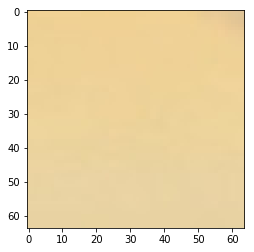

In [110]:
test_img = cv2.imread('./test_images/bbox-example-image.jpg')
plt.imshow(test_img)
fcfg,clf,X_scaler = load_model('models/svm_rbf',0)
patch = test_img[400:464,600:664,:]
plt.imshow(patch)

classify(patch,fcfg,clf,scaler)

[1.]
car 


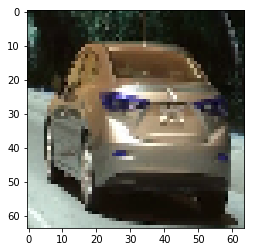

In [111]:
patch = test_img[490:690,830:1150,:]
patch = cv2.resize(patch,(64,64))
plt.imshow(patch)

classify(patch,fcfg,clf,scaler)

[1.]
car 


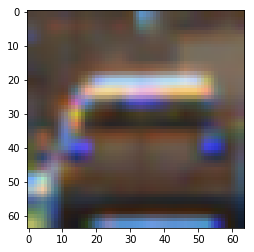

In [112]:
plt.imshow(car_ex)
classify(car_ex,fcfg,clf,scaler)

[1.]
car 


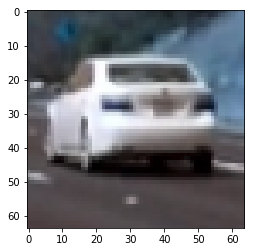

In [113]:
test_img = cv2.imread('./test_images/whitecar.png')
plt.imshow(test_img)
patch = cv2.resize(test_img,(64,64))
plt.imshow(patch)
classify(patch,fcfg,clf,scaler)

[1.]
car 


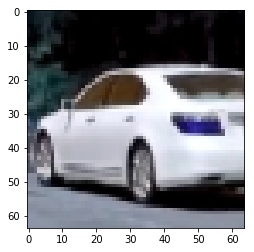

In [114]:
test_img = cv2.imread('./test_images/whitecar2.png')
plt.imshow(test_img)
patch = cv2.resize(test_img,(64,64))
plt.imshow(patch)
classify(patch,fcfg,clf,scaler)